# Overview

We will:

1. Estimate a production function using neural network 
2. Solve a optimization problem using the estimated function

In [103]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Single input power production

We will generate *i.i.d* samples of $(x_i, y_i)$ by the following procedure:

1. $\log x_i \sim \mathrm{Normal}(0, 1)$, $\log(\epsilon_i) \sim \mathrm{Normal}(0, 0.1)$
2. $y_i = \epsilon x_{i}^{\alpha}$, where $\alpha \in (0, 1)$ is predetermined.

Using the data $\{(x_i, y_i)\}_{i=1}^{n}$, we will estimate the function $f(x)$ that predicts $y$ by the neural network.

Then, we will solve the following (unconstrained) maximization problem:

$$
\mathrm{max}_{x}\;\; f(x) - p x
$$
where $p > 0$ is a known parameter that represents the input price. 

The solution with the true function with $\epsilon=1$ is $x^* = \left(\frac{p}{\alpha}\right)^{\frac{1}{\alpha-1}}$.
We expect that the optimization problem obtains a closer value to this.


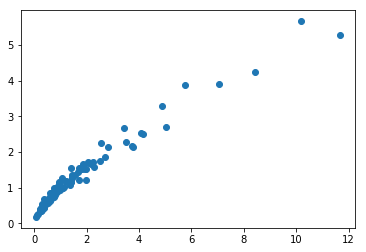

In [8]:
# define data generating functions
def power_product_func(x, epsilon, alpha):
    y = epsilon * np.power(x, alpha)
    return y

def generate_power_data(n, alpha):
    x = np.random.lognormal(0, 1, n)
    eps = np.random.lognormal(0, 0.1, n)
    y = power_product_func(x, eps, alpha)
    return x, y

# test
np.random.seed(87)
x, y = generate_power_data(100, 0.7)
plt.scatter(x, y)

In [286]:
# define estimating architecture
tf.reset_default_graph()

x_in = tf.placeholder(tf.float32, shape=[None, 1], name="x_in")
y_in = tf.placeholder(tf.float32, shape=[None, 1], name="y_in")

keep_prob = tf.placeholder_with_default(1.0, shape=(), name="keep_prob")
train_rate = tf.placeholder_with_default(0.2, shape=(), name="train_rate")
y_mean = tf.placeholder(tf.float32, shape=(), name="y_mean")
y_std  = tf.placeholder(tf.float32, shape=(), name="y_std")


## first hidden layer
w1 = tf.get_variable("w1", [1, 10], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.get_variable("b1", [1]     , initializer=tf.contrib.layers.xavier_initializer())
a1 = tf.nn.relu(tf.matmul(x_in, w1) + b1)
a1_drop = tf.nn.dropout(a1, keep_prob=keep_prob)

## second hidden layer
w2 = tf.get_variable("w2", [10, 10], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.get_variable("b2", [1]     , initializer=tf.contrib.layers.xavier_initializer())
a2 = tf.nn.relu(tf.matmul(a1_drop, w2) + b2)
a2_drop = tf.nn.dropout(a2, keep_prob=keep_prob)

## output layer
w3 = tf.get_variable("w3", [10, 1], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.get_variable("b3", [1]     , initializer=tf.contrib.layers.xavier_initializer())
yhat = tf.matmul(a2_drop, w3) + b3

## training
loss  = tf.reduce_mean(tf.square(yhat - y_in))
train = tf.train.GradientDescentOptimizer(train_rate).minimize(loss)

## prediction in the original scale
yhat_orig = yhat*y_std + y_mean

In [287]:
# data prep
np.random.seed(87)

alpha = 0.7
n_tr = 1000
# training data
x_tr, y_tr = generate_power_data(n_tr, alpha)
# test data
n_te = 250
x_te, y_te = generate_power_data(n_te, alpha)

# normalize x and y to mean zero and a unit variance
# we will normalize training data to be mean 0 and unit variance
# then apply the same conversion to the test data
standardizer = StandardScaler()
xy_tr = standardizer.fit_transform(np.vstack((x_tr, y_tr)).transpose())
xy_te = standardizer.transform(np.vstack((x_te, y_te)).transpose())

data = {x_in: xy_tr[:,0].reshape((n_tr, 1)), y_in: xy_tr[:,1].reshape((n_tr, 1)), 
        keep_prob: 0.7, train_rate: 0.1}
data_te = {x_in: xy_te[:,0].reshape((n_te, 1)),
           y_mean: standardizer.mean_[1], y_std: standardizer.var_[1]**0.5}

In [288]:
tf.set_random_seed(875)
nepoch = 5000
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(nepoch):
        sess.run(train, data)
        if i % (nepoch/10) == 0:
            print(i, ") loss:", sess.run(loss, data))
            
    print(sess.run(loss, data))

    # generate test data and predictioni
    yhat_te = sess.run(yhat_orig, data_te)
    parameters = {'w1': w1.eval(), 'b1': b1.eval(), 
                  'w2': w2.eval(), 'b2': b2.eval(),
                  'w3': w3.eval(), 'b3': b3.eval()}

0 ) loss: 1.14952
500 ) loss: 0.191199
1000 ) loss: 0.147089
1500 ) loss: 0.214928
2000 ) loss: 0.126705
2500 ) loss: 0.159594
3000 ) loss: 0.1824
3500 ) loss: 0.15743
4000 ) loss: 0.130589
4500 ) loss: 0.148584
0.148521


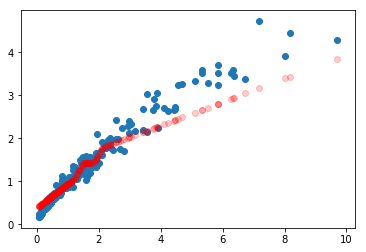

In [289]:
plt.scatter(x_te, y_te)
plt.scatter(x_te, yhat_te, c='r', alpha=0.2)

In [290]:
# define optimization architecture
tf.reset_default_graph()

## x is now a trainable variable
x_in = tf.Variable([[10.0]], dtype=tf.float32)
## first hidden layer
## note that parameters are now constant
w1 = tf.constant(parameters['w1'], dtype=tf.float32, name="w1")
b1 = tf.constant(parameters['b1'], dtype=tf.float32, name="b1")
a1 = tf.nn.relu(tf.matmul(x_in, w1) + b1)
#a1_drop = tf.nn.dropout(a1, keep_prob=keep_prob)  # no need anymore!

## second hidden layer
w2 = tf.constant(parameters['w2'], dtype=tf.float32, name="w2")
b2 = tf.constant(parameters['b2'], dtype=tf.float32, name="b2")
a2 = tf.nn.relu(tf.matmul(a1, w2) + b2)
# a2_drop = tf.nn.dropout(a2, keep_prob=keep_prob)

## output layer
w3 = tf.constant(parameters['w3'], dtype=tf.float32, name="w3")
b3 = tf.constant(parameters['b3'], dtype=tf.float32, name="b3")
yhat = tf.matmul(a2, w3) + b3

# normalize x back to the original scale
x_mean = tf.placeholder(tf.float32, shape=(), name="x_mean")
x_std  = tf.placeholder(tf.float32, shape=(), name="x_std")
x_orig = x_in * x_std + x_mean

y_mean = tf.placeholder(tf.float32, shape=(), name="y_mean")
y_std  = tf.placeholder(tf.float32, shape=(), name="y_std")
y_orig = yhat * y_std + y_mean


## optimizer
train_rate = tf.placeholder_with_default(0.2, shape=(), name="train_rate")
price= tf.placeholder(tf.float32, shape=(), name="price")
objective = price * x_orig - y_orig
train = tf.train.GradientDescentOptimizer(train_rate).minimize(objective)

In [291]:
tf.set_random_seed(875)
p = 0.25
data = {train_rate: 0.5, price: p,
        x_mean: standardizer.mean_[0], x_std: standardizer.var_[0]**0.5,
        y_mean: standardizer.mean_[1], y_std: standardizer.var_[1]**0.5}

nepoch = 300
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(nepoch):
        sess.run(train, data)
        
    x_star = x_orig.eval(data)[0][0]
print("x star =", x_star)
expected = (p/alpha)**(1/(alpha-1))
print("expected =", expected)


x star = 35.3955
expected = 30.94046035325769


### Two-input Cobb-Douglas Production

We will generate a dummy data of $(K, L, Y)$ from $Y = K^\alpha L^{1-\alpha}$ and estimate $Y = f(K, L)$ by neural net. Then, we will maximize: $f(K, L)$ subject to $r K + w L = M$.

This optimization problem has an analytic solution:

$K^* = \frac{\alpha M}{r}, L^* = \frac{(1-\alpha)M}{w}$